In [1]:
import tensorflow as tf
import random
import os 
import numpy as np 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd 
import matplotlib.pyplot as plt

### Path system

In [2]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'exercises1', 'Datasets', 'cookies_vs_chihuahua'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is c:\Users\itane\Documents\GitHub\ComputerVisionAndSensorFunsion\exercises1\Datasets\cookies_vs_chihuahua


### Dataset function

In [3]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to nam _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")
        return None, None, None

### Load train set

Here we want to load the training sets X_train and y_train. Here I resize these images to 224x224 pixels, which helps with normalization. It's also a popular size in many pre-calibrated large datasets, such as ImageNet. This size also gives some computational advantages as this size is not too large for processing, but it is still good for displaying the features needed.

In [4]:
# Load the training set
training_set_path = os.path.join(path_of_download, 'train')
X_train, y_train, name_of_the_labels = load_the_data_and_the_labels(training_set_path, target_size=(224, 224))
print(f"The training set has shape {X_train.shape} and the labels shape {y_train.shape}")

[WALK] I am walking into c:\Users\itane\Documents\GitHub\ComputerVisionAndSensorFunsion\exercises1\Datasets\cookies_vs_chihuahua\train\chihuahua
[WALK] I am walking into c:\Users\itane\Documents\GitHub\ComputerVisionAndSensorFunsion\exercises1\Datasets\cookies_vs_chihuahua\train\muffin
The training set has shape (4733, 224, 224, 3) and the labels shape (4733,)


### Load test set

Now let's do the same for the test set. I also resize these images to 224x224 pixels.

In [5]:
# Load the test set
test_set_path = os.path.join(path_of_download, 'test')
X_test, y_test, _ = load_the_data_and_the_labels(test_set_path, target_size=(224, 224))
print(f"The test set has shape {X_test.shape} and the labels shape {y_test.shape}")

[WALK] I am walking into c:\Users\itane\Documents\GitHub\ComputerVisionAndSensorFunsion\exercises1\Datasets\cookies_vs_chihuahua\test\chihuahua
[WALK] I am walking into c:\Users\itane\Documents\GitHub\ComputerVisionAndSensorFunsion\exercises1\Datasets\cookies_vs_chihuahua\test\muffin
The test set has shape (1184, 224, 224, 3) and the labels shape (1184,)


### Normalize the data

Now we want to normalize the data. Because normalization ensures that each feature has an equal impact on the performance of the model, it is an essential part of the whole data processing. Especially now when we are working with multilayer neural networks, normalization becomes even more important as gradients are calculated and updated.

The value 255 comes from the pixel values, where the images represents the intensity of colour in each pixel of the image.

For example, a value of 0 represents black with no light intensity. On the other hand, a value of 255 represents white, where light intensity is at its maximum. When we divide our data set by 255, all light intensity values will be somewhere between 0 and 1.

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Create a CNN with the following characteristics:
a.	Input layer
b.	Data augmentation, with random flip and random rotation.
c.	Two hidden layers each composed with the following characteristics: 16 conv2d units, max pooling 2d and batch normalization, the second one should have 24 conv2d units max pooling 2d and batch normalization. 
d.	After this, add a flatten layer and a dense layer with 8 units
e.	Add the final classifier (a  dense layer) with the correct number of output and activation


Now let's create our CNN model. To begin, we want to start by creating an input layer. This layer defines the format of the input data we have and what the model will accept.

In [7]:
# Define the input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

Now we apply some data augmentation where we add random flips and rotations to the images. This adds variation to the trained data, giving our model more different features to learn. The diversity in the dataset allows our model to perform better on real-world data, where image positions, rotations and orientation may also change.

In [8]:
# Apply some augmentation to the model.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Here we define the random flip to image be horizontal
    tf.keras.layers.RandomRotation(0.1) # 0.1 = 10% of 360 degrees, so image will rotate randomly between 0 and 36 degrees
])

Now we create two hidden layers which will be added to the model, one with 16 Conv2D units and the other with 24 Conv2D units. These units are the core building blocks of CNN models, which apply a number of filters to the input image to extract various patterns such as edges, textures and shapes from the images.

Both layers have ReLU activation, which helps the model learn more complex representations faster. ReLU (Rectified Linear Unit) is a function that adds non-linearity to the model. This function gives a direct output if it is positive, otherwise it gives a zero output.

Then MaxPooling2D is added, with a pool size of 2x2, which reduces the dimensions but preserves all the important features. This operation reduces the computational effort as a down-sampling operator and helps the model to prevent overfitting by making the model more invariant to small translations and distortions of the images.

Finally, we add Batch Normalization to both layers to help prevent interval covariance shifts and ultimately speed up training. This happens because the mean of each layer is zero and the standard deviation is one in each batch.

In [9]:
# First hidden layer
conv2d_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
conv2d_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_1) # Here we define the max pooling 2d with a 2x2 pool size
conv2d_1 = tf.keras.layers.BatchNormalization()(conv2d_1) # Here we define the batch normalization

# Second hidden layers
conv2d_2 = tf.keras.layers.Conv2D(24, (3, 3), activation='relu', padding='same')(conv2d_1)
conv2d_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_2) # Same max pooling as before
conv2d_2 = tf.keras.layers.BatchNormalization()(conv2d_2) # Same batch normalization as before

Now we have created the convolution layers and are creating a Flatten layer to convert two-dimensional features into a one-dimensional vector. In this way, we ensure that our input is suitable for a Dense layer that requires a one-dimensional input.

Once the Flatten layer is created, we add a 64-unit dense layer with ReLU activation. This layer is connected to a layer where a neuron is connected to every neuron before the final classification.

In [10]:
flatten = tf.keras.layers.Flatten()(conv2d_2)
dense_layer = tf.keras.layers.Dense(64, activation='relu')(flatten) # Dense layer with 64 neurons.

Finally, we add a final classifier, which concludes the result of the model. We create a final layer called output_layer, which is a dense layer with a sigmoidal activation function. The sigmoid function is suitable here because we have a value between a chihuahua and a muffin or between 0 and 1, which can be interpreted as a probability.

In [11]:
# num_units = len(name_of_the_labels)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer) # we use sigmoid activation to ensure the outputs are binary values.

### Compile the model using Adam 

Now it's time to put all the layers together and create our model. First, we just define the model and its input and output layers. Then we want to assemble the model and use the Adam optimizer as instructed. We want to use the binary_crossentropy function as the loss function because we have a binary output value. I also added an accuracy metric so we can see how the model learns during training.

Finally, I also added a summary table so that we can see that all the layers we created actually exist and how many parameters each contains.

In [12]:
# Creat the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 24)   │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,816,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,821,113 (18.39 MB)

 Trainable params: 4,821,033 (18.39 MB)

 Non-trainable params: 80 (320.00 B)

### Train the model with batch size 64 and epochs of 30

Now we do the training operation. We use 64 batch sizes and 30 epochs as instructed. The batch size determines how many samples we process before updating the weights of the model. Epochs, on the other hand, determine how many times we run the model through the entire dataset.

In [13]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=30)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.7260 - loss: 3.3849
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.8819 - loss: 0.2781
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9515 - loss: 0.1331
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - accuracy: 0.9836 - loss: 0.0559
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.9963 - loss: 0.0197
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.9988 - loss: 0.0097
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9997 - loss: 0.0080
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.9996 - loss: 0.0029
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9999 - loss: 0.0023
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 18

### Evaluate the model and report the accuracy.

Now when the model has been trained. We can start to evaluate its performance with test data. Here we want to use our X_test and y_test data to return the loss and accuracy of the model.

In [14]:
# Evaluate the model with the test set.
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8907 - loss: 0.5844
Test loss: 0.5830318331718445
Test accuracy: 0.8868243098258972


Our test result loss of 0.583.. is pretty high, which may indicate that there may be an overfitting. This means that we want to tune the hyperparameters of the model a bit.

However, the accuracy of 0.887... is quite good, indicating that the model performs well on unseen data.

Overall, I think we can still achieve better performance by changing the hyperparameters.

#### Make prediction with the test set and use a threshold of 0.5 as boundaries decision between the classes. 

Next, we make some predictions from the test set. As the instructions say, we want to use a threshold of 0.5 for the classification, so we use that. Then we print out some predictions to see in practice what the predictions are.

In [15]:
# Let's make predictions on the test set now
predictions = model.predict(X_test)

# We want to apply the threshold value of 0.5 for classification
predictions_binary = (predictions > 0.5).astype(int)

# Now print some of the predictions to see practical results on our eyes.
print(predictions_binary[:10])

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


As we can see, the result is either 0 or 1, which seems right for the binary classification problem. Since we use a sigmoid function in the output layer, the predictions are probabilities between 0 and 1, so we just use our threshold of 0.5, which means that values above 0.5 are classified as 1 and values below 0.5 are classified as 0.

### Plot confusion matrix and ROC curve

Now we want to plot the model's confusion matrix. I will use the ConfusionMatrixDisplay function from scikit-learn and plot that with Matplotlib.

Let's also define the True Positive Rate (FPR), True Positive Rate (TPR) and the threshold variable. Then we can use scitkit-learn's roc_curve function to create the ROC curve.

Finally, we plot the ROC curve.

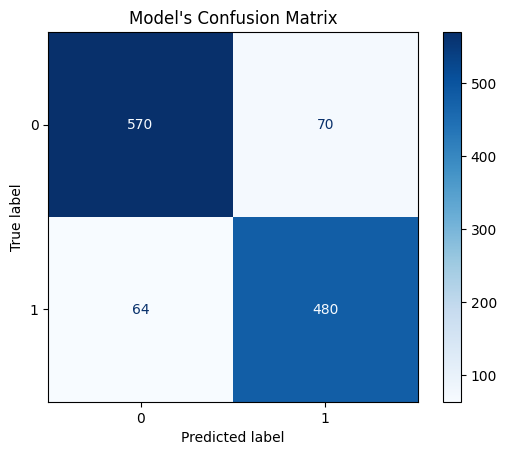

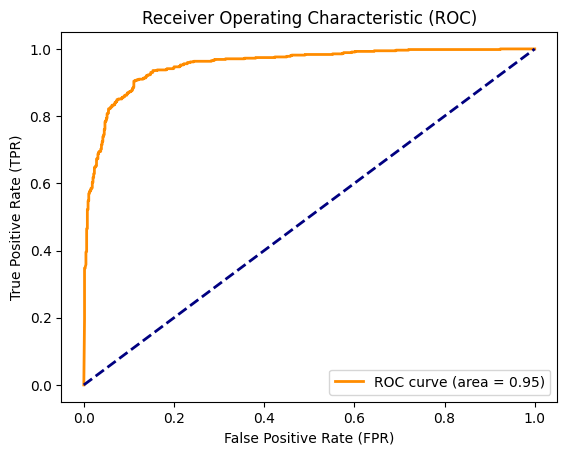

In [16]:
# Now we want to plot the confusions matrix of the model performance
conf_matrix = confusion_matrix(y_test, predictions_binary)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot(cmap='Blues')
plt.title("Model's Confusion Matrix")
plt.show()

# Now we want to plot the ROC curve.
# First, we need to calculate the False Positive Rate (FPR) and True Positive Rate (TPR).
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Now we can plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr)) # Here we can calculate the AUC also.
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Now we have both plots Confusion Matrix and ROC curve. The Confusion Matrix shows the following:

- True Positive (TP): 480
- False Positive (FP): 64
- True Negative (TN): 570
- False Negative (FN): 70

These values indicate that the classification is mostly correctly predicted.

Our ROC curve also shows nice upward curve towards top-left, which is good sign of the model's performace.

### Calcualte best testhold

Now we want to find the best threshold for the model. This can be done by maximizing the difference between True Positive Rate and False Positive Rate. Then we just want to choose a threshold where the model achieves a high recall value while minimizing false positives.

In [17]:
# Find the optimal threshold value by maximizing the TPR - FPR
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

# Now we can make the predictions by using the optimal threshold.
predictions_binary_optimal = (predictions > optimal_threshold).astype(int)

### Plot confusion matrix 

Now, finally we can plot the confusion matrix with the best optimal threshold value.

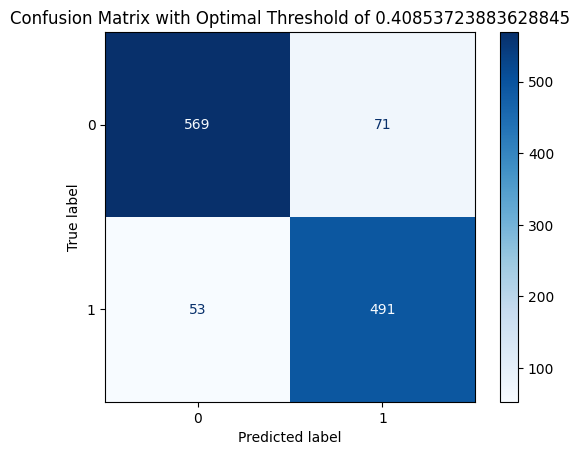

In [18]:
# Plot the confusion matrix again
conf_matrix_optimal = confusion_matrix(y_test, predictions_binary_optimal)
display = ConfusionMatrixDisplay(conf_matrix_optimal)
display.plot(cmap='Blues')
plt.title(f'Confusion Matrix with Optimal Threshold of {optimal_threshold}')
plt.show()

As we can see, we got higher values of correct predictions. Also, our threshold decreased to 0.409.., which means that our model is now little bit lesser selective in classifying positive cases.

- True Positive (TP): 491
- False Positive (FP): 53
- True Negative (TN): 569
- False Negative (FN): 71

With optimizing the threshold value, we reduced false positive cases, while still keeping a nice number of true positive cases. Overall this mean that our balance between sensitivtity has improved.